In [2]:
import tensorflow as tf
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
import os
from pathlib import Path

# load data 

In [25]:
train_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=(0.9, 1.1),
    horizontal_flip=True,
    vertical_flip=False
)

batch_size_1=32
batch_size_2=16

train_dir = "./images/cleaned"
IMG_HEIGHT, IMG_WIDTH = 128, 128

train_data_gen_1 = train_image_generator.flow_from_directory(batch_size=batch_size_1,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH))
train_data_gen_2 = train_image_generator.flow_from_directory(batch_size=batch_size_2,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH))



print(train_data_gen_1.class_indices)

Found 528 images belonging to 4 classes.
Found 528 images belonging to 4 classes.
{'Bier': 0, 'Cocktail': 1, 'Wasser': 2, 'Wein': 3}


## numbers for traininng

In [5]:
estimated_image_count = 600 #TODO count it
nr_samples = estimated_image_count
nr_epochs = 10 #TODO way more or early stop (see at training above)
steps_per_epoch_1 =  nr_samples / batch_size_1
steps_per_epoch_2 =  nr_samples / batch_size_2

## Utility function that will skip batches if there is a broken image in it

In [6]:
def skip_broken_images(gen):
    while True:
        try:
            data, labels = next(gen)
            yield data, labels
        except GeneratorExit:
            break
        except:
            pass

# display images

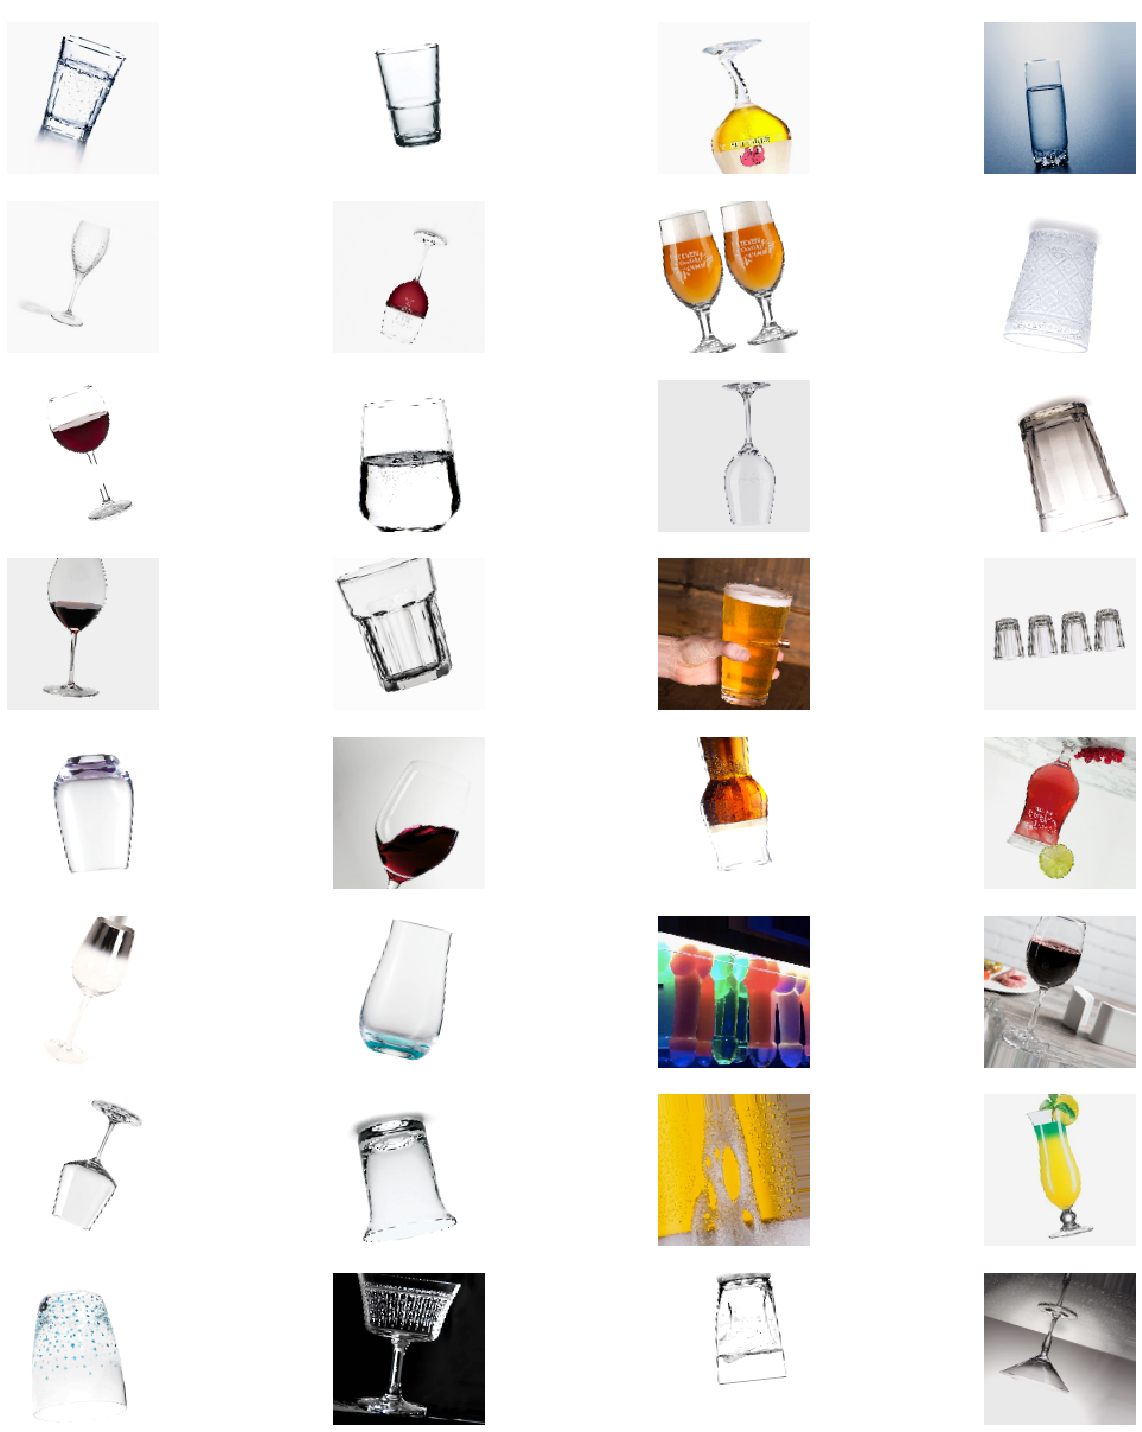

In [26]:
sample_training_images, labels = next(train_data_gen_1)
class_label = {v:k for k,v in train_data_gen_1.class_indices.items()}
fig, axes = plt.subplots(8, 4, figsize=(20,20))
axes = axes.flatten()
for img, label, ax in zip(sample_training_images, labels, axes):
    ax.set_title(class_label[np.argmax(label)])
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout()

# Model 1

In [18]:
model_1 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, kernel_initializer='lecun_normal', activation='selu'),
    tf.keras.layers.Dense(256, 'relu'),
    tf.keras.layers.Dense(train_data_gen_1.num_classes, 'softmax')
])
    
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 128, 128, 16)      448       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 64, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16384)             0

# Model 2

In [21]:
model_2 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, kernel_initializer='lecun_normal', activation='selu'),
    tf.keras.layers.Dense(256, 'relu'),
    tf.keras.layers.Dense(train_data_gen_2.num_classes, 'softmax')
])
    
model_2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 128, 128, 16)      448       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 128, 128, 32)      4640      
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 128, 128, 64)      18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 16384)            

# Train models and save trained model

In [24]:
def train_model(model, data_gen, steps_per_epoch, file_name):
    model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['categorical_accuracy'])

    history = model.fit_generator(
        skip_broken_images(data_gen),
        steps_per_epoch=steps_per_epoch, #use way more steps here: number of samples / batch size
        epochs=nr_epochs,# or EarlyStopping callback
        callbacks=[]
    )

    println(file_name)
    plt.plot(history.history['loss'])

    model.save(file_name)

train_model(model_1, train_data_gen_1, steps_per_epoch_1, 'drink-detection-model1-g1.h5')
train_model(model_1, train_data_gen_2, steps_per_epoch_2, 'drink-detection-model1-g2.h5')
train_model(model_2, train_data_gen_1, steps_per_epoch_1, 'drink-detection-model2-g1.h5')
train_model(model_2, train_data_gen_2, steps_per_epoch_2, 'drink-detection-model2-g2.h5')

s: 0.6205 - categorical_accuracy: 0.7390C:\Users\Michael\Anaconda3\envs\akt\lib\site-packages\PIL\Image.py:2817: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)
C:\Users\Michael\Anaconda3\envs\akt\lib\site-packages\PIL\Image.py:2817: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)
12/18 [==================>...........] - ETA: 25s - loss: 0.6184 - categorical_accuracy: 0.7487C:\Users\Michael\Anaconda3\envs\akt\lib\site-packages\PIL\Image.py:2817: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)
13/18 [===================>..........] - ETA: 23s - loss: 0.6100 - categorical_accuracy: 0.7482C:\Users\Michael\Anaconda3\envs\akt\lib\site-packages\PIL\Image.py:2817: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)
C:\Users\Michael\Anaconda3\envs\akt\lib\site-p

NameError: name 'println' is not defined